## Part II: Simulation

The inputs are the runs scored for both teams. I am going to use letters $x$ and $y$ to refer to the teams.

In the first prediction, I assume that both random variables -$rs_x$ and $rs_y$- follow a Weibull distribution whose parameters are determined in Part I.



In [207]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import gamma, factorial

In [ ]:
def PE(rs, ra, n_g, method = "basic"):
    """
    Computes PE given inputs "runs scored", "runs allowed", "number of games", and a specified method
    
    methods include: {basic, davenport, smyth}
    """
    
    if method == "basic":
        c = 1.83
        
    elif method == "davenport":     
        c =  1.50 * np.log10((rs+ra)/n_g) + 0.45     # is it log or log10? 
        
    elif method == "smyth":       
        c = ((rs+ra)/n_g)**0.287
        
    else:
        print("method not valid!")
    
    return (rs**c)/(rs**c + ra**c)

In [173]:
def scale_param(rs_avg, shape, beta = -0.5):
    """
    computes the scale parameter for RS, given the shape parameter
    """
    
    return (rs_avg - beta)/gamma(1 + 1.0/shape)
    

In [188]:
# Team x
shape_x   = 1.82
past_rs_x = 34       # cumulative runs scored by the end of last game
past_ra_x = 40       # cumulative runs allowed by the end of last game
game_n_x  = 5        # number of games palayed

# Team y
shape_y   = 1.82
past_rs_y = 41      # cumulative runs scored by the end of last game
past_ra_y = 39      # cumulative runs allowed by the end of last game
game_n_y  = 4       # number of games palayed



In [196]:
# simulation 
n_sim = 1000          # number of game simulations 
eps   = 1.75          # error tolerance
c_eps = 1.25         # |PPE - PE| <= eps/game_n**c_eps. needs discussion and calibration

tol_x = eps/(game_n_x**c_eps)   
tol_y = eps/(game_n_y**c_eps) 

sim_g = pd.DataFrame(columns = ['RS_x', 'RS_y', 'Pr_x', 'Pr_y', 'Pr_g', 'PPE_x', 'PPE_y', 'Accept'],
                                                                                      index = np.arange (0, n_sim))

# Observed PE at the end of last game
method  = "basic"
pe_x    = PE(past_rs_x, past_ra_x, game_n_x, method = method)  
pe_y    = PE(past_rs_y, past_ra_y, game_n_y, method = method) 

scale_x = scale_param(past_rs_x/game_n_x, shape_x)
scale_y = scale_param(past_rs_y/game_n_y, shape_y)

In [58]:
def draw_weibull(shape, scale):
    """
    returns a rv from a two-parmeter Weibull
    """
    return scale * np.random.weibull(shape)

In [111]:
def weibull_pdf(x, shape, scale):
    """
    Returns PDF of a given value x for a two-parmeter Weibull
    """
    if x >= 0:
        val = (shape/scale) * ((x/scale)**(shape-1.0)) * np.exp(-((x/scale)**shape))
    else:
        val = 0.0
    
    return val

In [50]:
def weibull_cdf(x, shape, scale):
    """
    Returns PDF of a given value x for a two-parmeter Weibull
    """
    if x >= 0:
        val = 1.0 - np.exp(-1.0 * (x/scale)**(shape))
    else:
        val = 0.0
    
    return val

In [241]:
# # random.seed(25)
# for i in np.arange (0, n_sim):
    
#     sim_g.loc[i, "RS_x"] = round(draw_weibull(shape_x, scale_x))
#     sim_g.loc[i, "RS_y"] = round(draw_weibull(shape_y, scale_y))
    
#     x_high = sim_g.loc[i, "RS_x"] + 0.5
#     x_low  = sim_g.loc[i, "RS_x"] - 0.5
    
#     y_high = sim_g.loc[i, "RS_y"] + 0.5
#     y_low  = sim_g.loc[i, "RS_y"] - 0.5
    
#     sim_g.loc[i, "Pr_x"] = weibull_cdf(x_high, shape_x, scale_x) - weibull_cdf(x_low, shape_x, scale_x) 
#     sim_g.loc[i, "Pr_y"] = weibull_cdf(y_high, shape_y, scale_y) - weibull_cdf(y_low, shape_y, scale_y) 
    
# # probability of (RS_x, RS_y) happening    
#     sim_g.loc[i, "Pr_g"] = sim_g.loc[i, "Pr_x"] * sim_g.loc[i, "Pr_y"]
    
# # runs for each team at the end of the game    
#     cum_rs_x = past_rs_x + sim_g.loc[i, "RS_x"]
#     cum_rs_y = past_rs_y + sim_g.loc[i, "RS_y"]
    
#     cum_ra_x = past_ra_x + cum_rs_y
#     cum_ra_y = past_ra_y + cum_rs_x
    
#     sim_g.loc[i, "PPE_x"] = PE(cum_rs_x, cum_ra_x, game_n_x, method = method)
#     sim_g.loc[i, "PPE_y"] = PE(cum_rs_y, cum_ra_y, game_n_y, method = method)
    
    
#     # is this game acceptable? yes, if for both PPEs |PPE - PE| < tol
#     delta_pe_x = np.abs(sim_g.loc[i, "PPE_x"] - pe_x)
#     delta_pe_y = np.abs(sim_g.loc[i, "PPE_y"] - pe_y)
    
    
#     if (delta_pe_x <= tol_x) and (delta_pe_y <= tol_y):
#         sim_g.loc[i, "Accept"] = 1     
#     else:
#         sim_g.loc[i, "Accept"] = 0
        
    

# print(" Simulation Stats: ")
# print("")
# print("accepted ratio: " , sim_g["Accept"].sum()/n_sim)
# print("RS_x range    : " , sim_g["RS_x"].min(), " to ", sim_g["RS_x"].max())
# print("RS_y range    : " , sim_g["RS_y"].min(), " to ", sim_g["RS_y"].max())
    

In [242]:
# only keep acceptable draws

sim_g = pd.DataFrame(columns = ['RS_x', 'RS_y', 'Pr_x', 'Pr_y', 'Pr_g', 'PPE_x', 'PPE_y', 'Prob', 'Res_x'],
                                                                                    index = np.arange (0, n_sim))
# random.seed(25)
i = 0
while (i < n_sim):
    
    rsx_now = round(draw_weibull(shape_x, scale_x))
    rsy_now = round(draw_weibull(shape_y, scale_y))
      
    prx_now = weibull_cdf(rsx_now + 0.5, shape_x, scale_x) - weibull_cdf(rsx_now - 0.5, shape_x, scale_x) 
    pry_now = weibull_cdf(rsy_now + 0.5, shape_y, scale_y) - weibull_cdf(rsy_now - 0.5, shape_y, scale_y) 
    

# runs for each team at the end of the game    
    cum_rs_x = past_rs_x + rsx_now
    cum_rs_y = past_rs_y + rsy_now
    
    cum_ra_x = past_ra_x + cum_rs_y
    cum_ra_y = past_ra_y + cum_rs_x
    
    ppe_x = PE(cum_rs_x, cum_ra_x, game_n_x, method = method)
    ppe_y = PE(cum_rs_y, cum_ra_y, game_n_y, method = method)
    
    
    # is this game acceptable? yes, if for both PPEs |PPE - PE| < to  
    
    if (np.abs(ppe_x - pe_x) <= tol_x) and (np.abs(ppe_y - pe_y) <= tol_y):
        
        sim_g.loc[i, "RS_x"]  = rsx_now
        sim_g.loc[i, "RS_y"]  = rsy_now
        sim_g.loc[i, "Pr_x"]  = prx_now
        sim_g.loc[i, "Pr_y"]  = pry_now
        sim_g.loc[i, "Pr_g"]  = prx_now * pry_now
        sim_g.loc[i, "PPE_x"] = ppe_x
        sim_g.loc[i, "PPE_y"] = ppe_y
        
        if (rsx_now > rsy_now):
            sim_g.loc[i, "Res_x"] = 1
        elif (rsx_now == rsy_now):
            sim_g.loc[i, "Res_x"] = 0
        else:
            sim_g.loc[i, "Res_x"] = -1
                
        i += 1
        
        
sim_g["Prob"] = sim_g.loc[:, "Pr_g"]/sim_g["Pr_g"].sum()   # adjusted probability
sim_g["Prob"] = sim_g["Prob"]/sim_g["Prob"].sum()



In [208]:
# sim_g

In [243]:
values, counts = np.unique(sim_g["Res_x"], return_counts=True)
print("For team x, Pr(win)  =  ", counts[2]/n_sim)
print("For team x, Pr(tie)  =  ", counts[1]/n_sim)
print("For team x, Pr(lose) =  ", counts[0]/n_sim)

For team x, Pr(win)  =   0.663
For team x, Pr(tie)  =   0.098
For team x, Pr(lose) =   0.239


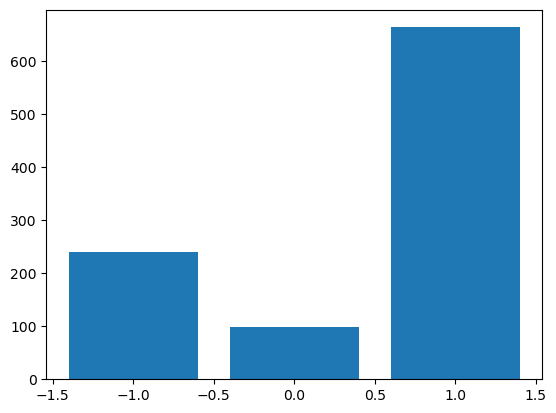

In [244]:
plt.bar(values, counts)
plt.show()

<Axes: title={'center': 'Predicted Runs by Team x'}, xlabel='RS_x', ylabel='Count'>

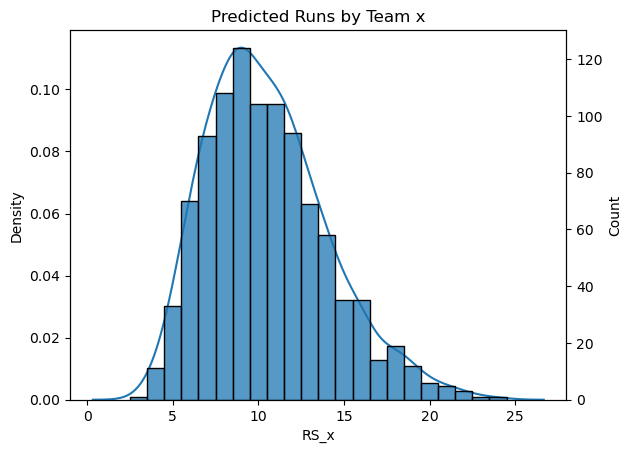

In [245]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.title ("Predicted Runs by Team x")

sns.kdeplot(data = sim_g, x = "RS_x", ax = ax1)
sns.histplot(data= sim_g, x = "RS_x", ax = ax2, discrete=True)


<Axes: title={'center': 'Predicted Runs by Team y'}, xlabel='RS_y', ylabel='Count'>

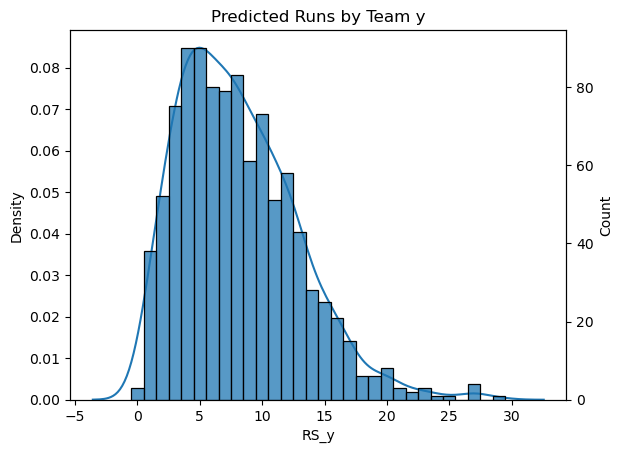

In [246]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.title ("Predicted Runs by Team y")

sns.kdeplot(data = sim_g, x = "RS_y", ax = ax1)
sns.histplot(data= sim_g, x = "RS_y", ax = ax2, discrete=True)